# Análisis de Sentimientos de tweets en español
El objetivo general de este proyecto es aplicar diversas herramientas y técnicas de Inteligencia Artificial (IA) para llevar a cabo el análisis y la presentación de datos de tweets en español, con la meta final de identificar oportunidades tecnológicas en este proceso

## 1. Importación de Librerías

In [1]:
# Importamos las librerías necesarias
import pandas as pd
import sqlite3
import io # Para simular la lectura de un CSV desde una cadena de texto
import re # Para expresiones regulares (limpieza de texto)
import nltk # Para procesamiento de lenguaje natural
import sys # Para salir del script en caso de error crítico
import joblib # Para guardar y cargar modelos
import time # Para añadir pausas si es necesario
import subprocess # Para ejecutar comandos de sistema
import threading # Para ejecutar flask en un hilo separado
import base64 # Para codificar imágenes en base64
import random
from datetime import datetime, timedelta
import numpy as np
import os # Para operaciones con el sistema de archivos

# --- Instalar Flask, pyngrok, SpaCy, fasttext y pyarrow (se ejecuta al inicio para asegurar disponibilidad) ---
print("Instalando Flask, pyngrok, spacy, fasttext y pyarrow...")
try:
    # Usamos !pip install directamente para una instalación más fiable al inicio del notebook
    # pyarrow es necesario para guardar/cargar DataFrames en formato Parquet
    !pip install Flask pyngrok spacy fasttext pyarrow
    print("Librerías instaladas correctamente.")
    time.sleep(1) # Pequeña pausa después de la instalación
except Exception as e:
    print(f"ERROR: No se pudo instalar una o más librerías. Detalle: {e}")
    print("Por favor, verifica tu conexión a internet o intenta reiniciar el entorno de ejecución.")
    sys.exit(1)

# Librería para Word Embeddings
import fasttext

# Librerías para Vectorización y Modelado
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt # Para visualizaciones
import seaborn as sns # Para visualizaciones mejoradas
from wordcloud import WordCloud # Para generar nubes de palabras

# Librerías para la interfaz web (Flask y pyngrok)
from flask import Flask, request, render_template_string
from pyngrok import ngrok
from pyngrok.exception import PyngrokNgrokError
import requests # Para manejar errores de conexión con ngrok

# --- Descargar modelo de español de SpaCy ---
print("Descargando modelo de español de SpaCy (es_core_news_sm)...")
try:
    # Esto descargará el modelo de español. Si ya existe, lo omitirá.
    !python -m spacy download es_core_news_sm --quiet
    print("Modelo de español de SpaCy descargado/verificado correctamente.")
except Exception as e:
    print(f"ERROR: No se pudo descargar el modelo de español de SpaCy. Detalle: {e}")
    print("Por favor, verifica tu conexión a internet o intenta de nuevo.")
    sys.exit(1)

import spacy # Importamos spacy después de asegurarnos de que esté instalado y el modelo descargado
nlp = spacy.load("es_core_news_sm") # Cargamos el modelo de español

# --- Montar Google Drive ---
print("Montando Google Drive...")
from google.colab import drive
try:
    drive.mount('/content/drive')
    print("Google Drive montado correctamente.")
except Exception as e:
    print(f"ERROR: No se pudo montar Google Drive. Detalle: {e}")
    print("Por favor, asegúrate de autorizar el acceso a Google Drive.")
    sys.exit(1)

# --- Cargar modelo FastText pre-entrenado para español desde Google Drive ---
FASTTEXT_MODEL_NAME = "cc.es.300.bin"
FASTTEXT_DRIVE_PATH = f"/content/drive/MyDrive/Colab Notebooks/TFM/fasttext_models/{FASTTEXT_MODEL_NAME}"

ft_model = None

# Intentar cargar el modelo desde Google Drive
print(f"\nIntentando cargar modelo FastText desde Google Drive: {FASTTEXT_DRIVE_PATH}...")
if os.path.exists(FASTTEXT_DRIVE_PATH):
    try:
        ft_model = fasttext.load_model(FASTTEXT_DRIVE_PATH)
        print("Modelo FastText cargado correctamente desde Google Drive.")
    except Exception as e:
        print(f"ERROR al cargar el modelo FastText desde Drive: {e}")
        print("Asegúrate de que el archivo no esté corrupto y que esté en la ruta correcta en Google Drive.")
        print("Si el problema persiste, intenta descargar el modelo manualmente de nuevo y subirlo a Drive.")
        sys.exit(1)
else:
    print(f"ERROR: Modelo FastText '{FASTTEXT_MODEL_NAME}' no encontrado en Google Drive en la ruta: {FASTTEXT_DRIVE_PATH}")
    print("Por favor, descarga el modelo manualmente desde https://fasttext.cc/docs/en/crawl-vectors.html (busca 'cc.es.300.bin')")
    print(f"Y súbelo a la carpeta '{os.path.dirname(FASTTEXT_DRIVE_PATH)}' en tu Google Drive.")
    sys.exit(1)

if ft_model is None:
    print("ERROR FATAL: No se pudo cargar el modelo FastText. El script no puede continuar.")
    sys.exit(1)

# --- Descargar recursos de NLTK ---
# Intentamos descargar los recursos 'stopwords' y 'punkt'.
# NLTK es inteligente y no los descargará de nuevo si ya existen.
print("\nVerificando y descargando recursos de NLTK (stopwords, punkt)...")
try:
    nltk.download('stopwords', quiet=True)
    print("Recurso 'stopwords' de NLTK descargado/verificado correctamente.")
except Exception as e:
    print(f"ERROR: No se pudo descargar el recurso 'stopwords'. Por favor, verifica tu conexión a internet o intenta de nuevo. Detalle: {e}")
    sys.exit(1) # Salir si no se puede descargar un recurso crítico

try:
    # Eliminamos quiet=True para ver el progreso y posibles errores de descarga de 'punkt'
    nltk.download('punkt')
    print("Recurso 'punkt' de NLTK descargado/verificado correctamente.")
except Exception as e:
    print(f"ERROR: No se pudo descargar el recurso 'punkt'. Por favor, verifica tu conexión a internet o intenta de nuevo. Detalle: {e}")
    sys.exit(1) # Salir si no se puede descargar un recurso crítico

# --- Descargar recurso adicional para NLTK (punkt_tab para español) ---
# La tokenización en español puede requerir este recurso específico en algunos casos.
print("Verificando y descargando recurso adicional de NLTK (punkt_tab para español)...")
try:
    # Intentamos descargar el recurso 'punkt_tab' para el idioma español
    nltk.download('punkt_tab', quiet=True)
    print("Recurso 'punkt_tab' para español de NLTK descargado/verificado correctamente.")
except Exception as e:
    print(f"ERROR: No se pudo descargar el recurso 'punkt_tab'. Por favor, verifica tu conexión a internet o intenta de nuevo. Detalle: {e}")
    sys.exit(1) # Salir si no se puede descargar un recurso crítico

Instalando Flask, pyngrok, spacy, fasttext y pyarrow...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 4.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.13.6-py3-none-any.whl.metadata (9.5 kB)
Using cached pybind11-2.13.6-py3-none-any.whl (243 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp311-cp311-linux_x86_64.whl size=4313501 sha256=0776250ae4c6cde9485a3eefb0e85749308d82db841ffad43ffb941e59dde164
  Stored in directory: /root/.cache/pip/wheels/65/4f/35/5057db0249224e9ab55a513fa6b79451473ceb7713017823c3
Successfully built fasttext
Librerías instaladas correctamente.
Descargando modelo de español de SpaCy (es_core_news_sm)...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 70.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload depend

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Recurso 'punkt' de NLTK descargado/verificado correctamente.
Verificando y descargando recurso adicional de NLTK (punkt_tab para español)...
Recurso 'punkt_tab' para español de NLTK descargado/verificado correctamente.


## 2. Carga de datasets

In [2]:
print("--- Configuración inicial del proyecto ---")

# --- Paso 1: Carga del Dataset desde CSV ---
print("\n--- Cargando Dataset desde CSV (df_csv) desde Google Drive ---")

# RUTA DEL ARCHIVO CSV EN GOOGLE DRIVE
csv_file_path = '/content/drive/MyDrive/Colab Notebooks/TFM/tweet_sentiment_spanish_csv.csv'

try:
    df_csv = pd.read_csv(csv_file_path)
    print(f"Dataset CSV cargado desde '{csv_file_path}'.")
    print("Primeras 5 filas del Dataset CSV:")
    print(df_csv.head())
    print(f"Número de filas en df_csv: {len(df_csv)}")
except FileNotFoundError:
    print(f"ERROR: El archivo CSV no se encontró en la ruta: {csv_file_path}")
    print("Asegúrate de que el archivo existe y la ruta es correcta.")
    sys.exit(1)
except Exception as e:
    print(f"ERROR al leer el archivo CSV desde Google Drive: {e}")
    print("Verifica el formato del CSV o si el archivo está dañado.")
    sys.exit(1)

# Definición del mapeo de números a texto para los sentimientos
num_to_text_sentiment = {0: 'negativo', 1: 'neutro', 2: 'positivo'}

# Asegurar que la columna 'sentimiento' sea numérica si viene como string
# Crear una columna de texto para las visualizaciones
if 'sentimiento' in df_csv.columns:
    # Intentar convertir la columna 'sentimiento' a numérica si es de tipo objeto
    df_csv['sentimiento'] = pd.to_numeric(df_csv['sentimiento'], errors='coerce')
    # Creación de la columna de texto para visualizaciones y la interfaz web
    df_csv['sentimiento_texto'] = df_csv['sentimiento'].map(num_to_text_sentiment)
    # Rellenar cualquier NaN que pueda surgir del mapeo si hay números fuera de 0,1,2
    df_csv['sentimiento_texto'].fillna('desconocido', inplace=True)
else:
    print("Advertencia: La columna 'sentimiento' no se encontró en el CSV. Asegúrate de que el nombre de la columna sea correcto.")
    sys.exit(1)

# --- Paso 2: Carga y almacenamiento del dataset en base de Datos (desde CSV de Drive) ---
print("\n--- Cargando Dataset para base de Datos (df_db) desde CSV de Google Drive ---")

# RUTA DEL ARCHIVO CSV PARA LA BASE DE DATOS EN GOOGLE DRIVE
# EL archivo CSV debe contener las columnas 'id_tweet' y 'texto_original'
csv_db_file_path = '/content/drive/MyDrive/Colab Notebooks/TFM/tweet_sentiment_spanish_db.csv'

try:
    df_db_load = pd.read_csv(csv_db_file_path)
    print(f"Dataset para la base de datos cargado desde '{csv_db_file_path}'.")
    print("Primeras 5 filas del Dataset para la base de datos:")
    print(df_db_load.head())
    print(f"Número de filas en df_db_load: {len(df_db_load)}")
except FileNotFoundError:
    print(f"ERROR: El archivo CSV para la base de datos no se encontró en la ruta: {csv_db_file_path}")
    print("Asegúrate de que el archivo existe y la ruta es correcta.")
    sys.exit(1)
except Exception as e:
    print(f"ERROR al leer el archivo CSV para la base de datos desde Google Drive: {e}")
    print("Verifica el formato del CSV o si el archivo está dañado.")
    sys.exit(1)

# Conexión a la base de datos SQLite en un archivo en Google Drive.
conn = sqlite3.connect('/content/drive/MyDrive/Colab Notebooks/TFM/tweets_data.db')
cursor = conn.cursor()

# SQL para crear la tabla de tweets en la base de datos
create_table_sql = """
CREATE TABLE IF NOT EXISTS tweets_raw (
    id_tweet INTEGER PRIMARY KEY,
    fecha_creacion TEXT,
    usuario TEXT,
    texto_original TEXT
);
"""
cursor.execute(create_table_sql)
print("Tabla 'tweets_raw' creada en la base de datos SQLite.")

# Opcional: Limpiar la tabla si se desea re-insertar datos en cada ejecución
# print("Limpiando tabla 'tweets_raw' antes de insertar nuevos datos (opcional)...")
# cursor.execute("DELETE FROM tweets_raw")
# conn.commit()
# print("Tabla 'tweets_raw' limpiada.")

# Insertar los datos del DataFrame en la base de datos
print("Insertando datos del CSV en la base de datos...")
try:
    # Preparar los datos para la inserción.
    # Archivo CSV debe tener 'id_tweet' y 'texto_original'.
    # Verificando que las columnas existan en df_db_load
    if 'id_tweet' not in df_db_load.columns or 'texto_original' not in df_db_load.columns:
        print("ERROR: El CSV para la base de datos debe contener 'id_tweet' y 'texto_original'.")
        sys.exit(1)

    # Convertir el DataFrame a una lista de tuplas para la inserción
    tweets_to_insert = []
    for index, row in df_db_load.iterrows():
        # Se genera fecha_creacion y usuario si no existen en el CSV para ajustarlos a la base de datos
        fecha_creacion = datetime.now().strftime('%Y-%m-%d %H:%M:%S') # Fecha actual
        usuario = 'usuario_generado' # Usuario por defecto
        tweets_to_insert.append((row['id_tweet'], fecha_creacion, usuario, row['texto_original']))

    # Insertar los datos en la tabla
    insert_sql = "INSERT OR IGNORE INTO tweets_raw (id_tweet, fecha_creacion, usuario, texto_original) VALUES (?, ?, ?, ?)"
    # Se utiliza INSERT OR IGNORE para evitar errores si id_tweet ya existe
    cursor.executemany(insert_sql, tweets_to_insert)
    conn.commit()
    print(f"{cursor.rowcount} nuevos tweets insertados en la base de datos.")
except sqlite3.IntegrityError as e:
    print(f"Advertencia: Error de integridad al insertar datos. Algunos tweets ya podrían existir (id_tweet duplicado). Detalle: {e}")
except Exception as e:
    print(f"ERROR al insertar datos en la base de datos: {e}")
    sys.exit(1)

# Cargar los datos de la base de datos a un DataFrame de Pandas
df_db = pd.read_sql_query("SELECT * FROM tweets_raw", conn)

print("\nPrimeras 5 filas del Dataset de Base de Datos:")
print(df_db.head())
print(f"Número de filas en df_db: {len(df_db)}")

# Se cierra la conexión a la base de datos
conn.close()

print("\n--- ¡Configuración inicial completada! ---")
print("Ahora existen dos DataFrames de Pandas listos para trabajar:")
print("  - 'df_csv': Contiene los tweets con su sentimiento pre-etiquetado.")
print("  - 'df_db': Contiene tweets de una base de datos para luego analizar su sentimiento).")

--- Configuración inicial del proyecto ---

--- Cargando Dataset desde CSV (df_csv) desde Google Drive ---
Dataset CSV cargado desde '/content/drive/MyDrive/Colab Notebooks/TFM/tweet_sentiment_spanish_csv.csv'.
Primeras 5 filas del Dataset CSV:
   tweet_id                                        texto_tweet  sentimiento
0         1  estoy hasta el ojete de que me digáis que teng...            0
1         2  @user Por?  Tenía pensado verla después de la ...            1
2         3                           Esto de estar feliz mola            2
3         4                             Ya no es tan divertido            0
4         5  @user te recuerdo que soy una persona que tien...            1
Número de filas en df_csv: 32709

--- Cargando Dataset para base de Datos (df_db) desde CSV de Google Drive ---


<ipython-input-2-31afe539c50d>:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_csv['sentimiento_texto'].fillna('desconocido', inplace=True)


Dataset para la base de datos cargado desde '/content/drive/MyDrive/Colab Notebooks/TFM/tweet_sentiment_spanish_db.csv'.
Primeras 5 filas del Dataset para la base de datos:
   id_tweet                                     texto_original
0         1  @user La prensa cada vez más desacreditada  De...
1         2  Uds locas por sun and moon me dieron ganas de ...
2         3  @user Buenos Vídeos.Se que llegadas a los 1.00...
3         4  El amanecer va a ser bien feo por el recuento ...
4         5  Hoy estaré en @user en zona de Humor ups! De A...
Número de filas en df_db_load: 1824
Tabla 'tweets_raw' creada en la base de datos SQLite.
Insertando datos del CSV en la base de datos...
0 nuevos tweets insertados en la base de datos.

Primeras 5 filas del Dataset de Base de Datos:
   id_tweet       fecha_creacion           usuario  \
0         1  2025-05-21 15:43:35  usuario_generado   
1         2  2025-05-21 15:43:35  usuario_generado   
2         3  2025-05-21 15:43:35  usuario_generado   

## 3. Preprocesamiento de texto

In [3]:
from nltk.corpus import stopwords

# --- Paso 3: Preprocesamiento de texto ---
print("\n--- Preprocesamiento de texto ---")

# Definimos las stopwords en español
spanish_stopwords = set(stopwords.words('spanish'))

def preprocess_tweet(text):
    """
    Limpia y preprocesa un tweet:
    - Convierte a minúsculas.
    - Elimina URLs, menciones de usuario (@usuario), hashtags (#hashtag).
    - Elimina puntuación y números.
    - Tokeniza el texto.
    - Elimina stopwords en español.
    - Lematiza los tokens.
    - Une las palabras limpias y lematizadas en una cadena de texto.
    """
    text = text.lower() # Convertir a minúsculas
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE) # Eliminar URLs
    text = re.sub(r'@\w+', '', text) # Eliminar menciones de usuario
    text = re.sub(r'#\w+', '', text) # Eliminar hashtags
    text = re.sub(r'\d+', '', text) # Eliminar números
    text = re.sub(r'[^\w\s]', '', text) # Eliminar puntuación
    text = re.sub(r'\s+', ' ', text).strip() # Eliminar espacios extra

    # Procesar el texto con SpaCy para tokenización y lematización
    doc = nlp(text)

    # Lematizar y filtrar stopwords
    filtered_tokens = [token.lemma_ for token in doc if token.text not in spanish_stopwords and token.is_alpha] # is_alpha para asegurar que son palabras

    return " ".join(filtered_tokens) # Unir tokens de nuevo en una cadena

# Rutas para guardar/cargar DataFrames procesados en Google Drive
# Caching de archivos procesados
PROCESSED_DATA_DIR = '/content/drive/MyDrive/Colab Notebooks/TFM/processed_dataframes/'
DF_CSV_PROCESSED_PATH = os.path.join(PROCESSED_DATA_DIR, 'df_csv_processed.parquet')
DF_DB_PROCESSED_PATH = os.path.join(PROCESSED_DATA_DIR, 'df_db_processed.parquet')

# Crear la carpeta de datos procesados en Drive si no existe
if not os.path.exists(PROCESSED_DATA_DIR):
    os.makedirs(PROCESSED_DATA_DIR)
    print(f"Carpeta '{PROCESSED_DATA_DIR}' creada en Google Drive para datos procesados.")

# --- Cargar o generar texto procesado para df_csv ---
load_df_csv_processed = False
if os.path.exists(DF_CSV_PROCESSED_PATH):
    print(f"Intentando cargar df_csv con texto procesado desde {DF_CSV_PROCESSED_PATH}...")
    try:
        df_csv_loaded_processed = pd.read_parquet(DF_CSV_PROCESSED_PATH)
        # Verificar que las columnas esenciales y el número de filas coincidan
        if 'texto_procesado' in df_csv_loaded_processed.columns and len(df_csv_loaded_processed) == len(df_csv):
            df_csv['texto_procesado'] = df_csv_loaded_processed['texto_procesado']
            print("df_csv con texto procesado cargado correctamente.")
            load_df_csv_processed = True
        else:
            print("Advertencia: El archivo Parquet de df_csv procesado no es válido o no coincide. Regenerando texto procesado.")
            if os.path.exists(DF_CSV_PROCESSED_PATH): os.remove(DF_CSV_PROCESSED_PATH) # Eliminar archivo corrupto
    except Exception as e:
        print(f"ERROR al cargar df_csv_processed.parquet: {e}. Regenerando texto procesado.")
        if os.path.exists(DF_CSV_PROCESSED_PATH): os.remove(DF_CSV_PROCESSED_PATH) # Eliminar archivo corrupto

if not load_df_csv_processed:
    print("Generando texto procesado para df_csv...")
    df_csv['texto_procesado'] = df_csv['texto_tweet'].apply(preprocess_tweet)
    # Guardar el DataFrame completo con la nueva columna 'texto_procesado'
    # Se incluye las columnas originales para que el df_csv sea completo al cargar
    df_csv.to_parquet(DF_CSV_PROCESSED_PATH, index=False)
    print(f"Texto procesado para df_csv generado y guardado en {DF_CSV_PROCESSED_PATH}.")


# --- Cargar o generar texto procesado para df_db ---
load_df_db_processed = False
if os.path.exists(DF_DB_PROCESSED_PATH):
    print(f"Intentando cargar df_db con texto procesado desde {DF_DB_PROCESSED_PATH}...")
    try:
        df_db_loaded_processed = pd.read_parquet(DF_DB_PROCESSED_PATH)
        if 'texto_procesado' in df_db_loaded_processed.columns and len(df_db_loaded_processed) == len(df_db):
            df_db['texto_procesado'] = df_db_loaded_processed['texto_procesado']
            print("df_db con texto procesado cargado correctamente.")
            load_df_db_processed = True
        else:
            print("Advertencia: El archivo Parquet de df_db procesado no es válido o no coincide. Regenerando texto procesado.")
            if os.path.exists(DF_DB_PROCESSED_PATH): os.remove(DF_DB_PROCESSED_PATH) # Eliminar archivo corrupto
    except Exception as e:
        print(f"ERROR al cargar df_db_processed.parquet: {e}. Regenerando texto procesado.")
        if os.path.exists(DF_DB_PROCESSED_PATH): os.remove(DF_DB_PROCESSED_PATH) # Eliminar archivo corrupto

if not load_df_db_processed:
    print("Generando texto procesado para df_db...")
    df_db['texto_procesado'] = df_db['texto_original'].apply(preprocess_tweet)
    # Guardar el DataFrame completo con la nueva columna 'texto_procesado'
    df_db.to_parquet(DF_DB_PROCESSED_PATH, index=False)
    print(f"Texto procesado para df_db generado y guardado en {DF_DB_PROCESSED_PATH}.")

print("\nPrimeras 5 filas del Dataset CSV con texto procesado:")
print(df_csv[['texto_tweet', 'texto_procesado', 'sentimiento', 'sentimiento_texto']].head()) # Se muestra la nueva columna

print("\nPrimeras 5 filas del Dataset de Base de Datos con texto procesado:")
print(df_db[['texto_original', 'texto_procesado']].head())

# --- Paso 4: Análisis exploratorio de datos ---
print("\nInformación general de df_csv:")
df_csv.info()

print("\nEstadísticas descriptivas de df_csv:")
print(df_csv.describe(include='all'))

print("\nConteo de valores nulos en df_csv:")
print(df_csv.isnull().sum())

print("\nDistribución de sentimientos en df_csv (numérica):")
print(df_csv['sentimiento'].value_counts())
print("\nDistribución de sentimientos en df_csv (texto para visualización):")
print(df_csv['sentimiento_texto'].value_counts())


print("\nLongitud de los tweets en df_csv (antes y después del preprocesamiento):")
df_csv['longitud_original'] = df_csv['texto_tweet'].apply(len)
df_csv['longitud_procesada'] = df_csv['texto_procesado'].apply(len)
print(df_csv[['longitud_original', 'longitud_procesada']].describe())

print("\nInformación general de df_db:")
df_db.info()

print("\nEstadísticas descriptivas de df_db:")
print(df_db.describe(include='all'))

print("\nConteo de valores nulos en df_db:")
print(df_db.isnull().sum())

print("\nLongitud de los tweets en df_db (antes y después del preprocesamiento):")
df_db['longitud_original'] = df_db['texto_original'].apply(len)
df_db['longitud_procesada'] = df_db['texto_procesado'].apply(len)
print(df_db[['longitud_original', 'longitud_procesada']].describe())

print("\n--- EDA y preprocesamiento de texto completados. ---")
print("Ahora los DataFrames 'df_csv' y 'df_db' tienen una nueva columna 'texto_procesado'.")


--- Preprocesamiento de texto ---
Intentando cargar df_csv con texto procesado desde /content/drive/MyDrive/Colab Notebooks/TFM/processed_dataframes/df_csv_processed.parquet...
df_csv con texto procesado cargado correctamente.
Intentando cargar df_db con texto procesado desde /content/drive/MyDrive/Colab Notebooks/TFM/processed_dataframes/df_db_processed.parquet...
df_db con texto procesado cargado correctamente.

Primeras 5 filas del Dataset CSV con texto procesado:
                                         texto_tweet  \
0  estoy hasta el ojete de que me digáis que teng...   
1  @user Por?  Tenía pensado verla después de la ...   
2                           Esto de estar feliz mola   
3                             Ya no es tan divertido   
4  @user te recuerdo que soy una persona que tien...   

                            texto_procesado  sentimiento sentimiento_texto  
0              ojete digáis cara malo leche            0          negativo  
1  pensado ver él después segundo da

## 4. Vectorización del texto

In [4]:
# --- Paso 5: Vectorización de texto (CON FASTTEXT EMBEDDINGS) ---
print("\n--- Vectorización de texto (FastText Embeddings) ---")

def get_fasttext_embedding(text, model):
    """
    Genera un embedding de oración promediando los embeddings de las palabras.
    Maneja textos vacíos o palabras fuera del vocabulario.
    """
    if not text:
        # Asegurar que el tipo de datos sea consistente aun para zero vectors
        return np.zeros(model.get_dimension(), dtype=np.float32)
    words = text.split()
    if not words:
         # Asegurar que el tipo de datos sea consistente aun para zero vectors
        return np.zeros(model.get_dimension(), dtype=np.float32)

    # Asegurar que solo se incluyan vectores de palabras válidos
    word_vectors = [model.get_word_vector(word).astype(np.float32) for word in words if word in model]

    if not word_vectors:
        # Asegurar que el tipo de datos sea consistente incluso si no hay palabras en el vocabulario del modelo
        return np.zeros(model.get_dimension(), dtype=np.float32)

    return np.mean(word_vectors, axis=0).astype(np.float32)

# Se guarda los embeddings. Implementación de caching
# Rutas para guardar/cargar DataFrames con embeddings en Google Drive
EMBEDDINGS_DIR = '/content/drive/MyDrive/Colab Notebooks/TFM/fasttext_embeddings_dataframes/'
DF_CSV_EMBEDDINGS_PATH = os.path.join(EMBEDDINGS_DIR, 'df_csv_with_fasttext_embeddings.parquet')
DF_DB_EMBEDDINGS_PATH = os.path.join(EMBEDDINGS_DIR, 'df_db_with_fasttext_embeddings.parquet')

# Crear la carpeta de embeddings en Drive si no existe
if not os.path.exists(EMBEDDINGS_DIR):
    os.makedirs(EMBEDDINGS_DIR)
    print(f"Carpeta '{EMBEDDINGS_DIR}' creada en Google Drive para embeddings.")

# --- Cargar o generar embeddings para df_csv ---
if os.path.exists(DF_CSV_EMBEDDINGS_PATH):
    print(f"Cargando embeddings para df_csv desde {DF_CSV_EMBEDDINGS_PATH}...")
    try:
        df_csv_with_embeddings = pd.read_parquet(DF_CSV_EMBEDDINGS_PATH)
        # Verificar que el 'texto_procesado' original y el 'sentimiento' estén en el df_csv cargado
        # Si el df_csv original tiene más columnas que solo el embedding
        # fusionar con el df_csv original si es necesario
        if 'fasttext_embedding' in df_csv_with_embeddings.columns and len(df_csv_with_embeddings) == len(df_csv):
            df_csv['fasttext_embedding'] = df_csv_with_embeddings['fasttext_embedding']
            print("Embeddings para df_csv cargados correctamente.")
        else:
            print("Advertencia: El archivo Parquet de df_csv no contiene la columna 'fasttext_embedding' o el número de filas no coincide. Regenerando embeddings.")
            raise FileNotFoundError # Forzar regeneración
    except Exception as e:
        print(f"ERROR al cargar df_csv_with_fasttext_embeddings.parquet: {e}. Regenerando embeddings.")
        # Si hay un error al cargar, eliminamos el archivo corrupto y regeneramos
        if os.path.exists(DF_CSV_EMBEDDINGS_PATH):
            os.remove(DF_CSV_EMBEDDINGS_PATH)
            print(f"Archivo corrupto {DF_CSV_EMBEDDINGS_PATH} eliminado.")
        # Forzar regeneración
        df_csv['fasttext_embedding'] = df_csv['texto_procesado'].apply(lambda x: get_fasttext_embedding(x, ft_model))
        # Guardar después de la generación
        df_csv[['fasttext_embedding', 'texto_procesado', 'sentimiento', 'sentimiento_texto']].to_parquet(DF_CSV_EMBEDDINGS_PATH, index=False)
        print(f"Embeddings para df_csv generados y guardados en {DF_CSV_EMBEDDINGS_PATH}.")
else:
    print("Generando FastText embeddings para df_csv...")
    df_csv['fasttext_embedding'] = df_csv['texto_procesado'].apply(lambda x: get_fasttext_embedding(x, ft_model))
    # Guardar después de la generación
    df_csv[['fasttext_embedding', 'texto_procesado', 'sentimiento', 'sentimiento_texto']].to_parquet(DF_CSV_EMBEDDINGS_PATH, index=False)
    print(f"Embeddings para df_csv generados y guardados en {DF_CSV_EMBEDDINGS_PATH}.")

# --- Cargar o generar embeddings para df_db ---
if os.path.exists(DF_DB_EMBEDDINGS_PATH):
    print(f"Cargando embeddings para df_db desde {DF_DB_EMBEDDINGS_PATH}...")
    try:
        df_db_with_embeddings = pd.read_parquet(DF_DB_EMBEDDINGS_PATH)
        if 'fasttext_embedding' in df_db_with_embeddings.columns and len(df_db_with_embeddings) == len(df_db):
            df_db['fasttext_embedding'] = df_db_with_embeddings['fasttext_embedding']
            print("Embeddings para df_db cargados correctamente.")
        else:
            print("Advertencia: El archivo Parquet de df_db no contiene la columna 'fasttext_embedding' o el número de filas no coincide. Regenerando embeddings.")
            raise FileNotFoundError # Forzar regeneración
    except Exception as e:
        print(f"ERROR al cargar df_db_with_fasttext_embeddings.parquet: {e}. Regenerando embeddings.")
        if os.path.exists(DF_DB_EMBEDDINGS_PATH):
            os.remove(DF_DB_EMBEDDINGS_PATH)
            print(f"Archivo corrupto {DF_DB_EMBEDDINGS_PATH} eliminado.")
        # Forzar regeneración
        df_db['fasttext_embedding'] = df_db['texto_procesado'].apply(lambda x: get_fasttext_embedding(x, ft_model))
        # Guardar después de la generación
        df_db[['fasttext_embedding', 'texto_original', 'texto_procesado']].to_parquet(DF_DB_EMBEDDINGS_PATH, index=False)
        print(f"Embeddings para df_db generados y guardados en {DF_DB_EMBEDDINGS_PATH}.")
else:
    print("Generando FastText embeddings para df_db...")
    df_db['fasttext_embedding'] = df_db['texto_procesado'].apply(lambda x: get_fasttext_embedding(x, ft_model))
    # Guardar después de la generación
    df_db[['fasttext_embedding', 'texto_original', 'texto_procesado']].to_parquet(DF_DB_EMBEDDINGS_PATH, index=False)
    print(f"Embeddings para df_db generados y guardados en {DF_DB_EMBEDDINGS_PATH}.")

# Eliminar filas donde no se pudo generar el embedding (ej. texto procesado vacío)
# Esto es importante para que los arrays de numpy no contengan 'None'
# Y para que las dimensiones coincidan si se eliminaron filas durante el apply
initial_csv_rows = len(df_csv)
initial_db_rows = len(df_db)
df_csv.dropna(subset=['fasttext_embedding'], inplace=True)
df_db.dropna(subset=['fasttext_embedding'], inplace=True)

if len(df_csv) < initial_csv_rows:
    print(f"Advertencia: Se eliminaron {initial_csv_rows - len(df_csv)} filas de df_csv debido a embeddings vacíos.")
if len(df_db) < initial_db_rows:
    print(f"Advertencia: Se eliminaron {initial_db_rows - len(df_db)} filas de df_db debido a embeddings vacíos.")

if not df_csv['fasttext_embedding'].empty:
    X_fasttext_csv = np.array(df_csv['fasttext_embedding'].tolist())
else:
    X_fasttext_csv = np.array([])

if not df_db['fasttext_embedding'].empty:
    X_fasttext_db = np.array(df_db['fasttext_embedding'].tolist())
else:
    X_fasttext_db = np.array([])


print(f"Dimensiones de la matriz FastText para df_csv: {X_fasttext_csv.shape}")
print(f"Dimensiones de la matriz FastText para df_db: {X_fasttext_db.shape}")
print("Vectorización con FastText Embeddings completada.")


--- Vectorización de texto (FastText Embeddings) ---
Cargando embeddings para df_csv desde /content/drive/MyDrive/Colab Notebooks/TFM/fasttext_embeddings_dataframes/df_csv_with_fasttext_embeddings.parquet...
Embeddings para df_csv cargados correctamente.
Cargando embeddings para df_db desde /content/drive/MyDrive/Colab Notebooks/TFM/fasttext_embeddings_dataframes/df_db_with_fasttext_embeddings.parquet...
Embeddings para df_db cargados correctamente.
Dimensiones de la matriz FastText para df_csv: (32709, 300)
Dimensiones de la matriz FastText para df_db: (1824, 300)
Vectorización con FastText Embeddings completada.


## 5. Modelado de análisis de sentimientos y evaluación


--- Modelado de análisis de sentimiento (usando FastText Embeddings) ---
Dimensiones del conjunto de entrenamiento (X_train): (26167, 300)
Dimensiones del conjunto de prueba (X_test): (6542, 300)
Modelo de Regresión Logística entrenado.

--- Evaluación del modelo ---
Precisión (Accuracy) en el conjunto de prueba: 0.6260

Reporte de Clasificación:
              precision    recall  f1-score   support

    negativo       0.66      0.71      0.68      2180
      neutro       0.54      0.53      0.53      2181
    positivo       0.68      0.64      0.66      2181

    accuracy                           0.63      6542
   macro avg       0.63      0.63      0.63      6542
weighted avg       0.63      0.63      0.63      6542


Matriz de confusión:
[[1555  468  157]
 [ 548 1150  483]
 [ 266  525 1390]]


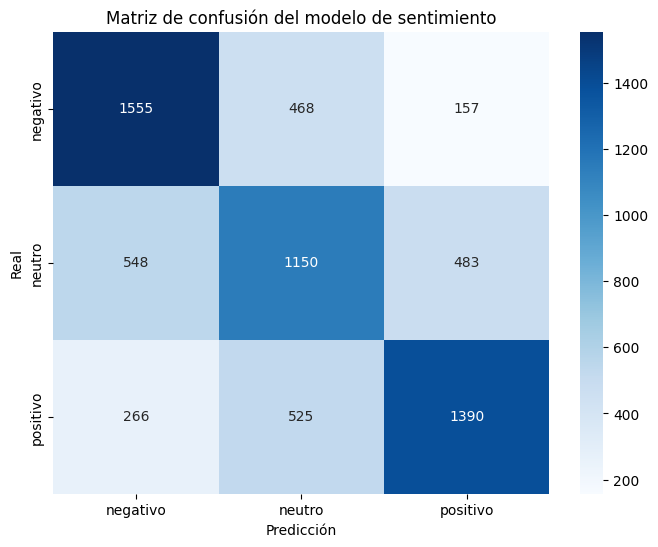


Modelo entrenado con FastText embeddings guardado en: /content/drive/MyDrive/Colab Notebooks/TFM/model_joblib/sentiment_model_fasttext.joblib

--- Aplicando el modelo al Dataset de la Base de Datos ---

Primeras 5 filas del Dataset de Base de Datos con sentimiento predicho:
                                      texto_original  \
0  @user La prensa cada vez más desacreditada  De...   
1  Uds locas por sun and moon me dieron ganas de ...   
2  @user Buenos Vídeos.Se que llegadas a los 1.00...   
3  El amanecer va a ser bien feo por el recuento ...   
4  Hoy estaré en @user en zona de Humor ups! De A...   

                                     texto_procesado  \
0  prensa cada vez desacreditado dejar ver televi...   
1  uds loca sun and moon dar gana jugar hablar st...   
2   buen vídeosse llegado subs seguir haci cuídate v   
3  amanecer ir ser bien feo recuento daño ojalá a...   
4  hoy zona humor ups amor fm solo desear él feli...   

   sentimiento_predicho_num sentimiento_predicho_t

In [5]:
# --- Paso 6: Modelado de análisis de sentimiento (usando FastText Embeddings) ---
print("\n--- Modelado de análisis de sentimiento (usando FastText Embeddings) ---")

if X_fasttext_csv.size == 0:
    print("ERROR: El dataset de entrenamiento (df_csv) está vacío después de generar embeddings. No se puede entrenar el modelo.")
    sys.exit(1)

X = X_fasttext_csv
y = df_csv['sentimiento']

# Dividimos el dataset CSV en conjuntos de entrenamiento y prueba
# test_size=0.20 significa que el 20% de los datos se usarán para la prueba
# random_state para reproducibilidad
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

print(f"Dimensiones del conjunto de entrenamiento (X_train): {X_train.shape}")
print(f"Dimensiones del conjunto de prueba (X_test): {X_test.shape}")

# Inicializar y entrenar un modelo de Regresión Logística
sentiment_model = LogisticRegression(max_iter=1000, random_state=42)
sentiment_model.fit(X_train, y_train)
print("Modelo de Regresión Logística entrenado.")

# Predicciones en el conjunto de prueba
y_pred = sentiment_model.predict(X_test)

# Evaluación del rendimiento del modelo
print("\n--- Evaluación del modelo ---")
print(f"Precisión (Accuracy) en el conjunto de prueba: {accuracy_score(y_test, y_pred):.4f}")
print("\nReporte de Clasificación:")
# Para el reporte de clasificación, se mapea los números a texto para mejor legibilidad
target_names_report = [num_to_text_sentiment[i] for i in sentiment_model.classes_]
print(classification_report(y_test, y_pred, target_names=target_names_report))

# Matriz de Confusión
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nMatriz de confusión:")
print(conf_matrix)

# Visualización de la matriz de Confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names_report, yticklabels=target_names_report) # Usamos etiquetas de texto
plt.title('Matriz de confusión del modelo de sentimiento')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

# Ruta para guardar el modelo en Google Drive
MODEL_JOBLIB_DIR = '/content/drive/MyDrive/Colab Notebooks/TFM/model_joblib/'
MODEL_JOBLIB_PATH = os.path.join(MODEL_JOBLIB_DIR, 'sentiment_model_fasttext.joblib')

# Crear la carpeta de embeddings en Drive si no existe
if not os.path.exists(MODEL_JOBLIB_DIR):
    os.makedirs(EMBEDDINGS_DIR)
    print(f"Carpeta '{MODEL_JOBLIB_DIR}' creada en Google Drive para model_joblib.")

if not os.path.exists(MODEL_JOBLIB_PATH):
    print(f"Guardando modelo en {MODEL_JOBLIB_PATH}...")
    # --- Guardar el modelo ---
    joblib.dump(sentiment_model, MODEL_JOBLIB_PATH)

print(f"\nModelo entrenado con FastText embeddings guardado en: {MODEL_JOBLIB_PATH}")


# --- Aplicar el modelo al Dataset de la Base de Datos (df_db) ---
print("\n--- Aplicando el modelo al Dataset de la Base de Datos ---")

if X_fasttext_db.size == 0:
    print("Advertencia: El dataset de la base de datos (df_db) está vacío después de generar embeddings. No se realizarán predicciones.")
    df_db['sentimiento_predicho_num'] = None
    df_db['sentimiento_predicho_texto'] = None
else:
    df_db['sentimiento_predicho_num'] = sentiment_model.predict(X_fasttext_db)
    df_db['sentimiento_predicho_texto'] = df_db['sentimiento_predicho_num'].map(num_to_text_sentiment)


print("\nPrimeras 5 filas del Dataset de Base de Datos con sentimiento predicho:")
print(df_db[['texto_original', 'texto_procesado', 'sentimiento_predicho_num', 'sentimiento_predicho_texto']].head())

print("\nDistribución de sentimientos predichos en df_db (numérica):")
print(df_db['sentimiento_predicho_num'].value_counts())
print("\nDistribución de sentimientos predichos en df_db (texto para visualización):")
print(df_db['sentimiento_predicho_texto'].value_counts())

print("\n--- Modelado de análisis de sentimiento completado. ---")

## 6. Visualizaciones Adicionales


--- Visualizaciones Adicionales de los Resultados ---


<ipython-input-7-729c1020abb5>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentimiento_texto', data=df_csv, palette='viridis')


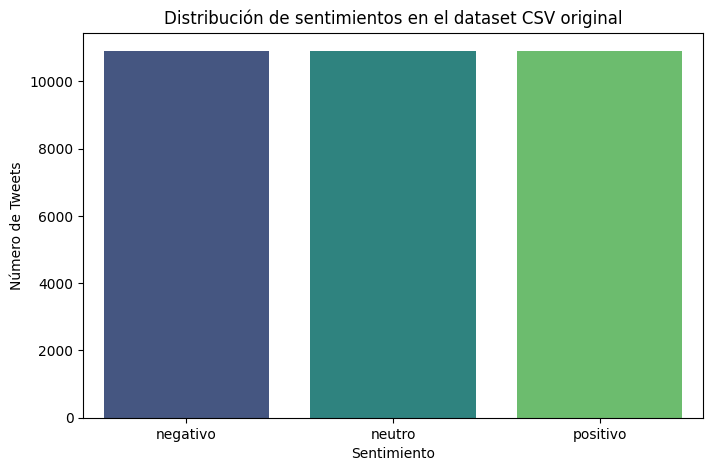

Visualización: Distribución de sentimientos en el dataset CSV original.


<ipython-input-7-729c1020abb5>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentimiento_predicho_texto', data=df_db, palette='magma')


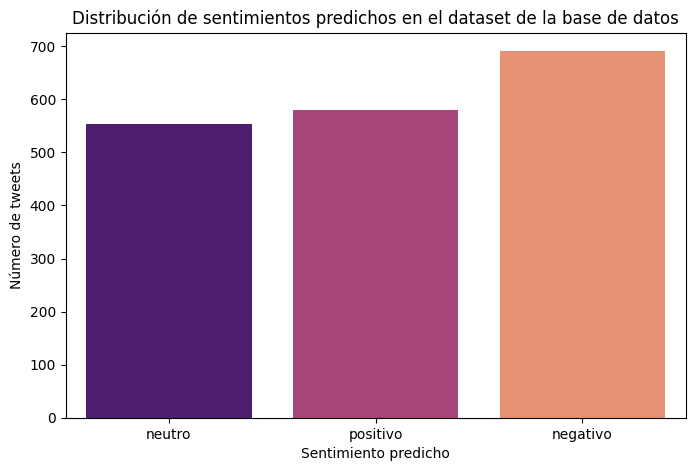

Visualización: Distribución de sentimientos predichos en el dataset de la base de datos.


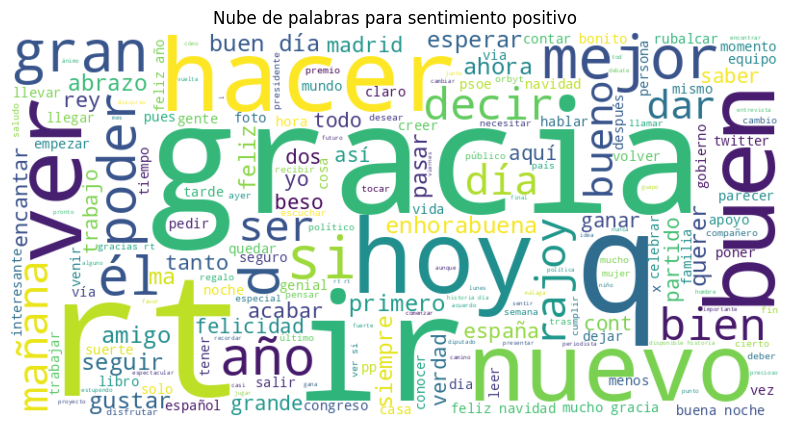

Visualización: Nube de palabras para tweets con sentimiento positivo.


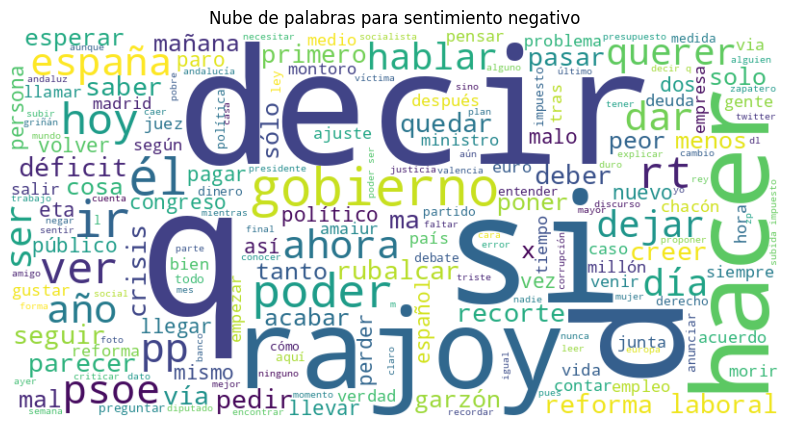

Visualización: Nube de palabras para tweets con sentimiento negativo.


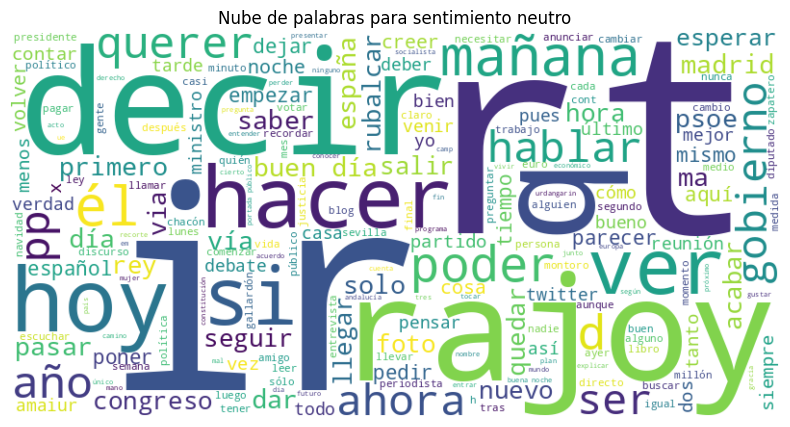

Visualización: Nube de palabras para tweets con sentimiento neutro.


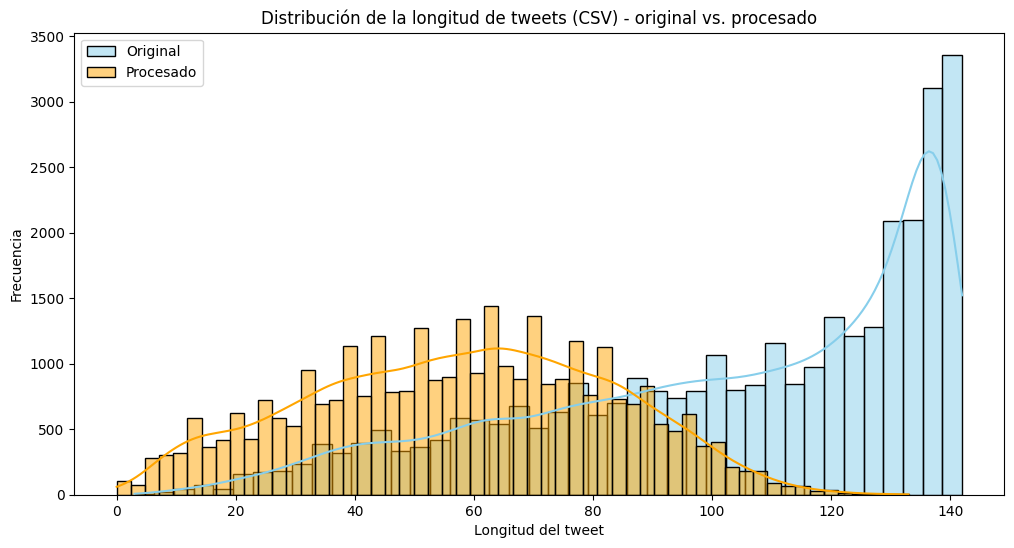

Visualización: Histograma de longitud de tweets (CSV) antes y después del preprocesamiento.


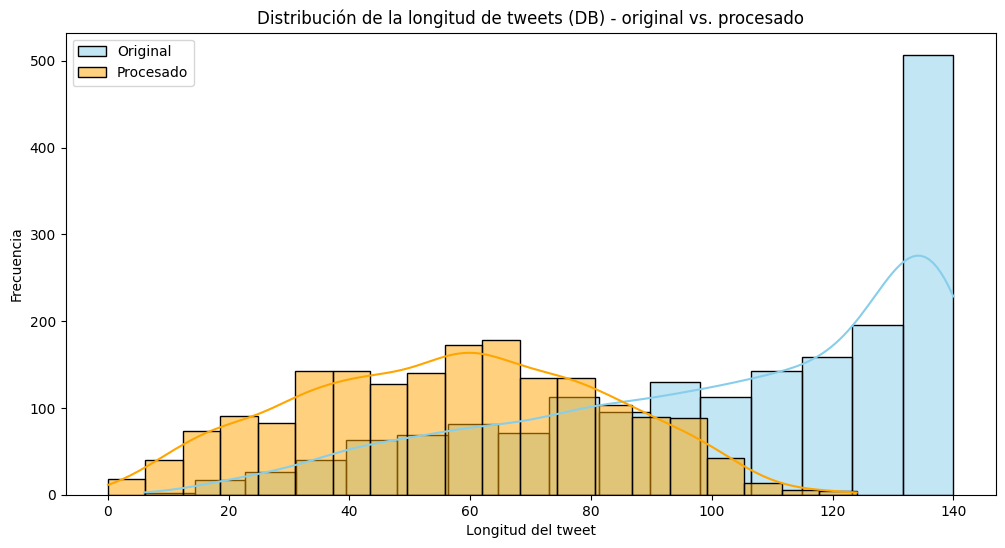

Visualización: Histograma de longitud de tweets (DB) antes y después del preprocesamiento.

--- Todas las visualizaciones completadas. ---
Ahora tienes gráficos que te ayudarán a entender mejor tus datos y los resultados del análisis de sentimiento.


In [7]:
# --- Paso 7: Visualizaciones Adicionales ---
print("\n--- Visualizaciones Adicionales de los Resultados ---")

# 7.1. Distribución de sentimientos en el dataset CSV (original - usando texto)
plt.figure(figsize=(8, 5))
sns.countplot(x='sentimiento_texto', data=df_csv, palette='viridis')
plt.title('Distribución de sentimientos en el dataset CSV original')
plt.xlabel('Sentimiento')
plt.ylabel('Número de Tweets')
plt.show()
print("Visualización: Distribución de sentimientos en el dataset CSV original.")

# 7.2. Distribución de sentimientos predichos en el dataset de la base de datos (usando texto)
plt.figure(figsize=(8, 5))
sns.countplot(x='sentimiento_predicho_texto', data=df_db, palette='magma')
plt.title('Distribución de sentimientos predichos en el dataset de la base de datos')
plt.xlabel('Sentimiento predicho')
plt.ylabel('Número de tweets')
plt.show()
print("Visualización: Distribución de sentimientos predichos en el dataset de la base de datos.")

# 7.3. Nube de Palabras para cada Sentimiento (del Dataset CSV - usando texto)
# Aseguramos que solo las palabras procesadas se usen para las nubes de palabras
all_words_positive = ' '.join(df_csv[df_csv['sentimiento_texto'] == 'positivo']['texto_procesado'])
all_words_negative = ' '.join(df_csv[df_csv['sentimiento_texto'] == 'negativo']['texto_procesado'])
all_words_neutral = ' '.join(df_csv[df_csv['sentimiento_texto'] == 'neutro']['texto_procesado'])

# Generar y mostrar Nube de palabras para sentimiento positivo
if all_words_positive: # Solo si hay palabras para generar la nube
    wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(all_words_positive)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud_positive, interpolation='bilinear')
    plt.axis('off')
    plt.title('Nube de palabras para sentimiento positivo')
    plt.show()
    print("Visualización: Nube de palabras para tweets con sentimiento positivo.")
else:
    print("No hay suficientes palabras positivas para generar la nube de palabras.")


# Generar y mostrar Nube de palabras para sentimiento negativo
if all_words_negative: # Solo si hay palabras para generar la nube
    wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(all_words_negative)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud_negative, interpolation='bilinear')
    plt.axis('off')
    plt.title('Nube de palabras para sentimiento negativo')
    plt.show()
    print("Visualización: Nube de palabras para tweets con sentimiento negativo.")
else:
    print("No hay suficientes palabras negativas para generar la nube de palabras.")

# Generar y mostrar Nube de palabras para sentimiento neutro
if all_words_neutral: # Solo si hay palabras para generar la nube
    wordcloud_neutral = WordCloud(width=800, height=400, background_color='white').generate(all_words_neutral)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud_neutral, interpolation='bilinear')
    plt.axis('off')
    plt.title('Nube de palabras para sentimiento neutro')
    plt.show()
    print("Visualización: Nube de palabras para tweets con sentimiento neutro.")
else:
    print("No hay suficientes palabras neutras para generar la nube de palabras.")


# 7.4. Histograma de longitud de tweets (original vs. procesado)
plt.figure(figsize=(12, 6))
sns.histplot(df_csv['longitud_original'], color='skyblue', label='Original', kde=True)
sns.histplot(df_csv['longitud_procesada'], color='orange', label='Procesado', kde=True)
plt.title('Distribución de la longitud de tweets (CSV) - original vs. procesado')
plt.xlabel('Longitud del tweet')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()
print("Visualización: Histograma de longitud de tweets (CSV) antes y después del preprocesamiento.")

plt.figure(figsize=(12, 6))
sns.histplot(df_db['longitud_original'], color='skyblue', label='Original', kde=True)
sns.histplot(df_db['longitud_procesada'], color='orange', label='Procesado', kde=True)
plt.title('Distribución de la longitud de tweets (DB) - original vs. procesado')
plt.xlabel('Longitud del tweet')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()
print("Visualización: Histograma de longitud de tweets (DB) antes y después del preprocesamiento.")


print("\n--- Todas las visualizaciones completadas. ---")
print("Ahora tienes gráficos que te ayudarán a entender mejor tus datos y los resultados del análisis de sentimiento.")


## 7. Exportación del dataset final

In [8]:
# --- Paso 8: Exportación del dataset final ---
print("\n--- Exportar el dataset final ---")

# Seleccionar las columnas relevantes para el dataset final
# Se incluye el texto original, el texto procesado y el sentimiento predicho (el texto)
df_final = df_db[['id_tweet', 'fecha_creacion', 'usuario', 'texto_original', 'texto_procesado', 'sentimiento_predicho_texto']]

# Exportar el dataFrame final a un archivo CSV
# index=False para no incluir el índice de pandas en el CSV
output_csv_path = 'tweets_final_con_sentimiento.csv'
df_final.to_csv(output_csv_path, index=False)

print(f"Dataset final exportado a: {output_csv_path}")


--- Exportar el dataset final ---
Dataset final exportado a: tweets_final_con_sentimiento.csv


## 8. Interfaz web con flask y pyngrok

In [9]:
# --- Paso 9: Interfaz web con flask y pyngrok ---
print("\n--- Iniciando interfaz web con flask y pyngrok ---")

# Puerto en el que Flask se ejecutará
FLASK_PORT = 5000

app = Flask(__name__)

# Función para convertir un gráfico de matplotlib a una imagen Base64
def plot_to_base64(fig):
    buffer = io.BytesIO()
    fig.savefig(buffer, format='png', bbox_inches='tight')
    plt.close(fig) # Cierra la figura para liberar memoria
    buffer.seek(0)
    img_base64 = base64.b64encode(buffer.getvalue()).decode('utf-8')
    return img_base64

# HTML para la interfaz web (usando Tailwind CSS para un diseño básico y responsivo)
html_template = """
<!DOCTYPE html>
<html lang="es">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Análisis de Sentimiento de Tweets</title>
    <script src="https://cdn.tailwindcss.com"></script>
    <link href="https://fonts.googleapis.com/css2?family=Inter:wght@400;600&display=swap" rel="stylesheet">
    <style>
        body { font-family: 'Inter', sans-serif; }
    </style>
</head>
<body class="bg-gray-100 min-h-screen flex items-center justify-center p-4">
    <div class="bg-white p-8 rounded-lg shadow-xl w-full max-w-md">
        <h1 class="text-3xl font-bold text-center text-gray-800 mb-6">Análisis de Sentimiento de Tweets</h1>
        <form action="/" method="post" class="space-y-4">
            <label for="tweet_text" class="block text-gray-700 text-sm font-semibold mb-2">Introduce un tweet:</label>
            <textarea id="tweet_text" name="tweet_text" rows="4"
                      class="w-full p-3 border border-gray-300 rounded-lg focus:ring-2 focus:ring-blue-500 focus:border-blue-500 transition duration-200 ease-in-out resize-y"
                      placeholder="¿Qué estás pensando?" required>{{ tweet_text if tweet_text else '' }}</textarea>
            <button type="submit"
                    class="w-full bg-blue-500 text-white font-bold py-2 px-4 rounded-full hover:bg-blue-600 focus:outline-none focus:ring-2 focus:ring-blue-500 focus:ring-offset-2 transition duration-200 ease-in-out text-lg">
                Publicar
            </button>
        </form>

        {% if sentiment_result %}
            <div class="mt-8 p-4 rounded-md
                {% if sentiment_result == 'positivo' %} bg-green-100 text-green-800 border border-green-300
                {% elif sentiment_result == 'negativo' %} bg-red-100 text-red-800 border border-red-300
                {% else %} bg-yellow-100 text-yellow-800 border border-yellow-300
                {% endif %}
                text-center font-semibold text-lg">
                Sentimiento Predicho: <span class="capitalize">{{ sentiment_result }}</span>
            </div>
        {% endif %}

        {% if plot_input_tweet_sentiment %}
            <div class="mt-8">
                <h2 class="text-xl font-bold text-gray-800 mb-4 text-center">Probabilidad de sentimiento del tweet ingresado</h2>
                <img src="data:image/png;base64,{{ plot_input_tweet_sentiment }}" class="w-full h-auto rounded-lg shadow-md" alt="Probabilidad de sentimiento del tweet ingresado">
            </div>
        {% endif %}

        {% if plot_original_sentiment %}
            <div class="mt-8">
                <h2 class="text-xl font-bold text-gray-800 mb-4 text-center">Distribución de sentimientos (Dataset original)</h2>
                <img src="data:image/png;base64,{{ plot_original_sentiment }}" class="w-full h-auto rounded-lg shadow-md" alt="Distribución de sentimientos Original">
            </div>
        {% endif %}

        {% if plot_predicted_sentiment %}
            <div class="mt-8">
                <h2 class="text-xl font-bold text-gray-800 mb-4 text-center">Distribución de sentimientos (Dataset predicho)</h2>
                <img src="data:image/png;base64,{{ plot_predicted_sentiment }}" class="w-full h-auto rounded-lg shadow-md" alt="Distribución de sentimientos Predicho">
            </div>
        {% endif %}
    </div>
</body>
</html>
"""

# Cargar el modelo desde el Google Drive
try:
    MODEL_JOBLIB_DIR = '/content/drive/MyDrive/Colab Notebooks/TFM/model_joblib/'
    MODEL_JOBLIB_PATH = os.path.join(MODEL_JOBLIB_DIR, 'sentiment_model_fasttext.joblib')
    loaded_model = joblib.load(MODEL_JOBLIB_PATH)
    print("Modelo cargado para la interfaz web.")
except FileNotFoundError:
    print(f"ERROR: Archivo de modelo no encontrado en la ruta: {MODEL_JOBLIB_PATH}")
    print("Asegúrate de que el modelo se haya guardado correctamente en Google Drive en el paso anterior.")
    sys.exit(1)
except Exception as e:
    print(f"ERROR al cargar el modelo de sentimiento para la interfaz web: {e}")
    sys.exit(1)

@app.route('/', methods=['GET', 'POST'])
def home():
    sentiment_result = None
    tweet_text = None
    plot_input_tweet_sentiment = None
    plot_original_sentiment = None
    plot_predicted_sentiment = None

    # Generar el gráfico de distribución de sentimientos original (df_csv)
    fig_original, ax_original = plt.subplots(figsize=(7, 4))
    sns.countplot(x='sentimiento', data=df_csv, palette='viridis', ax=ax_original)
    ax_original.set_title('Distribución de Sentimientos en el Dataset CSV Original')
    ax_original.set_xlabel('Sentimiento')
    ax_original.set_ylabel('Número de Tweets')
    plt.tight_layout()
    plot_original_sentiment = plot_to_base64(fig_original)

    # Generar el gráfico de distribución de sentimientos predichos (df_db)
    # Lo generamos siempre para que aparezca al cargar la página, no solo al hacer POST
    fig_predicted, ax_predicted = plt.subplots(figsize=(7, 4))
    sns.countplot(x='sentimiento_predicho_texto', data=df_db, palette='magma', ax=ax_predicted)
    ax_predicted.set_title('Distribución de sentimientos predichos en el dataset de la base de datos')
    ax_predicted.set_xlabel('Sentimiento predicho')
    ax_predicted.set_ylabel('Número de tweets')
    plt.tight_layout()
    plot_predicted_sentiment = plot_to_base64(fig_predicted)


    if request.method == 'POST':
        tweet_text = request.form['tweet_text']
        if tweet_text:
            # Preprocesar el texto del tweet
            processed_text = preprocess_tweet(tweet_text)
            # Vectorizar el texto
            vectorized_text = get_fasttext_embedding(processed_text, ft_model)

            if vectorized_text is None or vectorized_text.size == 0:
                sentiment_result = "No se pudo analizar (texto vacío o sin palabras reconocidas)."
            else:
                # El modelo espera una entrada 2D (1 muestra, N características)
                vectorized_text = vectorized_text.reshape(1, -1)
                # Predecir el sentimiento (número)
                sentiment_prediction_num = loaded_model.predict(vectorized_text)[0]
                # Mapear el sentimiento predicho a texto para mostrarlo en la interfaz
                sentiment_result = num_to_text_sentiment.get(sentiment_prediction_num, 'desconocido')


            # --- Generar gráfico de probabilidades para el tweet ingresado ---
            sentiment_probabilities = loaded_model.predict_proba(vectorized_text)[0]
            sentiment_classes = loaded_model.classes_ # Obtener el orden de las clases

            # Crear un DataFrame para el gráfico de probabilidades
            proba_df = pd.DataFrame({
                'Sentimiento': [num_to_text_sentiment[cls_num] for cls_num in sentiment_classes],
                'Probabilidad': sentiment_probabilities
            })

            fig_input_tweet, ax_input_tweet = plt.subplots(figsize=(7, 4))
            sns.barplot(x='Sentimiento', y='Probabilidad', data=proba_df, palette='coolwarm', ax=ax_input_tweet)
            ax_input_tweet.set_title('Probabilidad de sentimiento para el tweet Ingresado')
            ax_input_tweet.set_ylim(0, 1) # Asegurar que el eje Y vaya de 0 a 1
            plt.tight_layout()
            plot_input_tweet_sentiment = plot_to_base64(fig_input_tweet)


    return render_template_string(html_template,
                                  sentiment_result=sentiment_result,
                                  tweet_text=tweet_text,
                                  plot_input_tweet_sentiment=plot_input_tweet_sentiment,
                                  plot_original_sentiment=plot_original_sentiment,
                                  plot_predicted_sentiment=plot_predicted_sentiment)

# Función para iniciar ngrok en un hilo separado con reintentos
def start_ngrok_tunnel(port, retries=5, delay=5):
    print(f"Intentando iniciar ngrok para el puerto {port}...")

     # Ruta del archivo de authtoken en Google Drive
    NGROK_AUTH_TOKEN_PATH = '/content/drive/MyDrive/Colab Notebooks/TFM/ngrok_config/token_ngrok'

    # Crear la carpeta de configuración si no existe
    ngrok_config_dir = os.path.dirname(NGROK_AUTH_TOKEN_PATH)
    if not os.path.exists(ngrok_config_dir):
        os.makedirs(ngrok_config_dir)
        print(f"Carpeta '{ngrok_config_dir}' creada en Google Drive para configuración de ngrok.")

    auth_token = None
    if os.path.exists(NGROK_AUTH_TOKEN_PATH):
        try:
            with open(NGROK_AUTH_TOKEN_PATH, 'r') as f:
                auth_token = f.read().strip()
            if auth_token:
                ngrok.set_auth_token(auth_token)
                print("Authtoken de ngrok cargado desde Google Drive.")
            else:
                print(f"Advertencia: El archivo '{NGROK_AUTH_TOKEN_PATH}' está vacío. Por favor, pega tu authtoken de ngrok en él.")
        except Exception as e:
            print(f"ERROR al leer el authtoken de ngrok desde Drive: {e}")
            print(f"Por favor, asegúrate de que el archivo '{NGROK_AUTH_TOKEN_PATH}' contenga solo tu authtoken.")
    else:
        print(f"Archivo de authtoken de ngrok no encontrado en: {NGROK_AUTH_TOKEN_PATH}")
        print("Por favor, crea este archivo en tu Google Drive y pega tu authtoken de ngrok dentro.")
        print("Puedes obtener tu authtoken en: https://dashboard.ngrok.com/get-started/your-authtoken")
        sys.exit(1) # Salir si no se puede obtener el authtoken

    # Limpiar cualquier proceso ngrok anterior para evitar conflictos
    ngrok.kill() # Usamos ngrok.kill() directamente para limpiar procesos anteriores
    time.sleep(1) # Pausa para asegurar la limpieza

    for i in range(retries):
        try:
            public_url = ngrok.connect(port)
            print(f"\n¡ngrok iniciado! Accede a tu aplicación en la URL pública: {public_url}")
            return public_url
        except (PyngrokNgrokError, requests.exceptions.ConnectionError) as e:
            print(f"Intento {i+1}/{retries} fallido al conectar ngrok: {e}")
            if i < retries - 1:
                print(f"Reintentando en {delay} segundos...")
                time.sleep(delay)
            else:
                print("Máximo número de reintentos alcanzado. No se pudo iniciar ngrok.")
                return None
        except Exception as e:
            print(f"ERROR inesperado al iniciar ngrok: {e}")
            return None
    return None

# Iniciar ngrok en un hilo separado para no bloquear la ejecución de Flask
ngrok_thread = threading.Thread(target=start_ngrok_tunnel, args=(FLASK_PORT,))
ngrok_thread.daemon = True # Permite que el hilo termine cuando el programa principal lo haga
ngrok_thread.start()

# Ejecutar la aplicación Flask
# Asegúrate de que Flask se ejecute en el puerto especificado
app.run(port=FLASK_PORT)



--- Iniciando interfaz web con flask y pyngrok ---
Modelo cargado para la interfaz web.
Intentando iniciar ngrok para el puerto 5000...
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


Authtoken de ngrok cargado desde Google Drive.

¡ngrok iniciado! Accede a tu aplicación en la URL pública: NgrokTunnel: "https://4304-34-23-228-94.ngrok-free.app" -> "http://localhost:5000"


<ipython-input-9-af7bad3d54fe>:106: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentimiento', data=df_csv, palette='viridis', ax=ax_original)
<ipython-input-9-af7bad3d54fe>:116: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentimiento_predicho_texto', data=df_db, palette='magma', ax=ax_predicted)
INFO:werkzeug:127.0.0.1 - - [23/May/2025 12:15:25] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [23/May/2025 12:15:27] "GET /favicon.ico HTTP/1.1" 404 -
<ipython-input-9-af7bad3d54fe>:106: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.cou